### Instructions
This script is for training a multi-class classification model CNN from the given dataset using Keras + Tensorflow stack.
1. Configure the paramers as required
2. Configure the model as required
3. Run all the cells (cell > Run all)

### Imports

imports the required modules from keras, Tensorflow, PIL, numpy and custom file handling functions

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers, regularizers, models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle, randint
import numpy as np
import future
from keras.applications import VGG16
from PIL import Image

import matplotlib.pyplot as plt

from os import listdir, mkdir
from os.path import join, isfile, isdir, exists, expanduser
from shutil import rmtree, copyfile
from utils.file_utils import make_dir_helper, delete_dir_helper, is_jpeg
from keras.models import load_model, model_from_json

### Configurable parameters
Defines various constants, directory paths and design of the model

In [2]:
project_dir_name = join('desktop','Esri Project')
original_dataset_dir = join(expanduser('~'), project_dir_name, 'datasets', 'redlands dataset');
base_dir =  join(expanduser('~'), project_dir_name, 'temp data');
base_scripts_dir =  join(expanduser('~'), project_dir_name, 'scripts');
model_dir =  join(expanduser('~'),  project_dir_name, 'models');

MODEL_FILE_NAME = 'redlands_multi_classifier_model.h5'

CLASSES_TO_CLASSIFY = ['agricultural', 'buildings', 'land', 'parking', 'residential', 'roads']
print(CLASSES_TO_CLASSIFY)
NO_OF_CLASSES = len(CLASSES_TO_CLASSIFY)

ext = '.jpg'
IMAGE_SIZE = 128
EPOCHS = 30
BATCH_SIZE = 15
STEPS_PER_EPOCH = 5

# Define the model
def configure_model():
    
    model = models.Sequential()
    conv_base = VGG16(weights='imagenet' ,include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    for layer in conv_base.layers:
        if 'block_5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(NO_OF_CLASSES, activation='softmax'))
    return model;

['agricultural', 'buildings', 'land', 'parking', 'residential', 'roads']


### Make required directories
Make the directories for training data, validation data & testing data

In [3]:
# Delete the previous data folder and all its contents
delete_dir_helper(base_dir)

# Define train, test and validation directories
train_dir = join(base_dir, 'train')
validation_dir = join(base_dir, 'validation')
test_dir = join(base_dir, 'test')
model_file_path = join(model_dir, MODEL_FILE_NAME)

make_dir_helper(base_dir)
make_dir_helper(model_dir)

# Make base directories
make_dir_helper(train_dir)
make_dir_helper(validation_dir)
make_dir_helper(test_dir)

for classes in CLASSES_TO_CLASSIFY:
    
    train_class_dir = join(train_dir, classes)
    validation_class_dir = join(validation_dir, classes)
    test_class_dir = join(test_dir, classes)
    
    # Make train sub directories
    make_dir_helper(train_class_dir)
    make_dir_helper(validation_class_dir)
    make_dir_helper(test_class_dir)
    
    
    original_dataset_class_dir = join(original_dataset_dir, classes)
    fnames = [fname for fname in listdir(original_dataset_class_dir) if isfile(join(original_dataset_class_dir,fname)) and is_jpeg(fname)]
    
    no_of_samples = len(fnames)
    shuffle(fnames)
    
    no_of_samples_cut = round(no_of_samples * 0.7)
    
    for idx, fname in enumerate(fnames):
        
        src_dir = join(original_dataset_class_dir, fname)
        if idx < no_of_samples_cut:
            dst_dir = join(train_class_dir, fname)
            copyfile(src_dir, dst_dir)
        elif no_of_samples_cut <= idx < no_of_samples:
            dst_dir = join(validation_class_dir, fname)
            copyfile(src_dir, dst_dir)
            
            dst_dir = join(test_class_dir, fname)
            copyfile(src_dir, dst_dir)

### Build the CNN Model
Design a CNN model for multi-label classification. The model is designed on top the original VGG 16 dataset which produces the most accurate model

NO saved model with name redlands_multi_classifier_model.h5
Found 2239 images belonging to 6 classes.
Found 960 images belonging to 6 classes.
data batch: (15, 128, 128, 3)
labels batch: (15, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 16,813,638
Trainable params: 2,098,950
Non-trainable params: 14,7

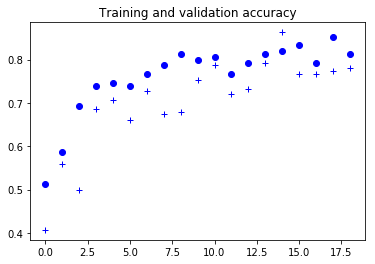

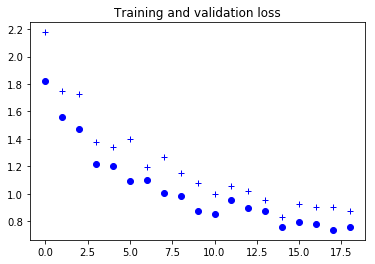

In [4]:
def compile_model(model):
    
    model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])
    model.summary()

model = None
if exists(model_file_path):
    model = load_model(model_file_path)
    print('Found saved model with name ' + MODEL_FILE_NAME)
    compile_model(model)

else:
    print('NO saved model with name ' + MODEL_FILE_NAME)   
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       vertical_flip=True,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True)  
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            train_dir,  
            target_size=(IMAGE_SIZE, IMAGE_SIZE),  
            batch_size=BATCH_SIZE,
            class_mode='categorical')  

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    for idx, (data_batch, labels_batch) in enumerate(train_generator):
        print('data batch:', data_batch.shape)
        print('labels batch:', labels_batch.shape)
        break

    model = configure_model()

    compile_model(model)

    callbacks = [
        EarlyStopping(monitor='acc', patience=3, mode='auto'),
        ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=model_file_path)
    ]
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks = callbacks,
        validation_steps=10)

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b+')
    plt.plot(epochs, val_acc, 'bo')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'b+')
    plt.plot(epochs, val_loss, 'bo')
    plt.title('Training and validation loss')

    plt.show()

### Evaluate the model 
Evalute the model using a confusion matrix to understand the performance of the model

In [5]:
for curr_class in CLASSES_TO_CLASSIFY: 
    
    dir_name = join(test_dir, curr_class);
    no_of_samples = len(listdir(dir_name))
    
    test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            classes = [curr_class],
            shuffle=False,
            save_format='jpeg',
            class_mode=None)
    predictions = model.predict_generator(test_generator, (no_of_samples // BATCH_SIZE) + 1 , max_queue_size=10, workers=8, use_multiprocessing=False, verbose=0)
   
    correct_count = 0
    
    print(predictions.shape)
    
    for idx, prediction in enumerate(predictions):
        
        max_val = np.amax(prediction)
        max_index = np.argmax(prediction)
        pred_class = CLASSES_TO_CLASSIFY[max_index]
        
        if curr_class == pred_class:
            correct_count += 1
      
    print(curr_class + ':' + str(correct_count / len(predictions) * 100))

Found 81 images belonging to 1 classes.
(81, 6)
agricultural:71.60493827160494
Found 69 images belonging to 1 classes.
(69, 6)
buildings:88.40579710144928
Found 94 images belonging to 1 classes.
(94, 6)
land:91.48936170212765
Found 87 images belonging to 1 classes.
(87, 6)
parking:32.18390804597701
Found 158 images belonging to 1 classes.
(158, 6)
residential:66.45569620253164
Found 471 images belonging to 1 classes.
(471, 6)
roads:95.75371549893843
